In [81]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout


In [82]:
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler           
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")


In [83]:
file_path = "stock_tweets.csv"
data = pd.read_csv(file_path)

In [84]:


data


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [85]:
stock_name="AMZN"
data_df = data[data['Stock Name'] == stock_name]
print(data_df.shape)
data_df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [86]:
#allocating blank columns in the data 

sentiment_df = data_df.copy()
sentiment_df["sentiment_score"] = ''
sentiment_df["Negative"] = ''
sentiment_df["Neutral"] = ''
sentiment_df["Positive"] = ''
sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",,,,


In [87]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

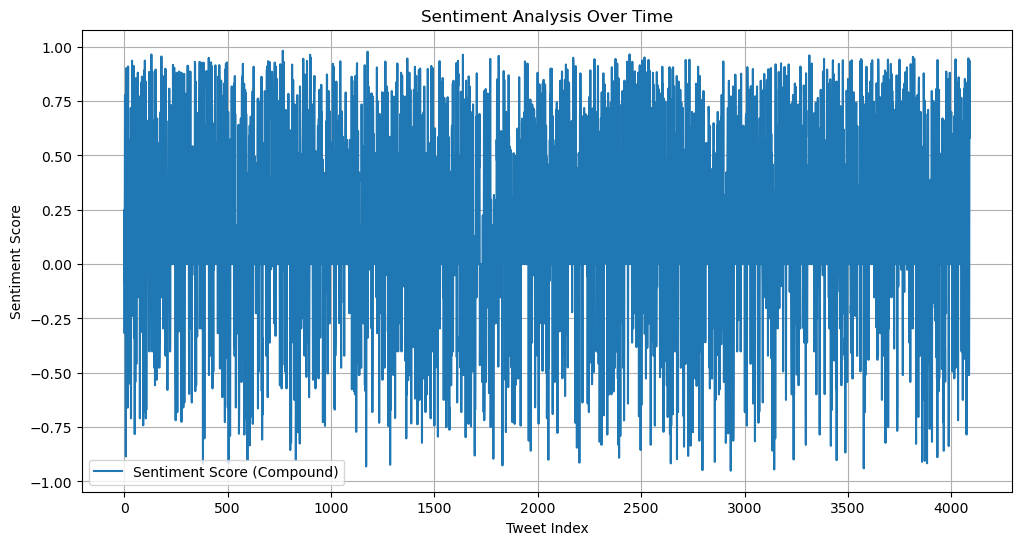

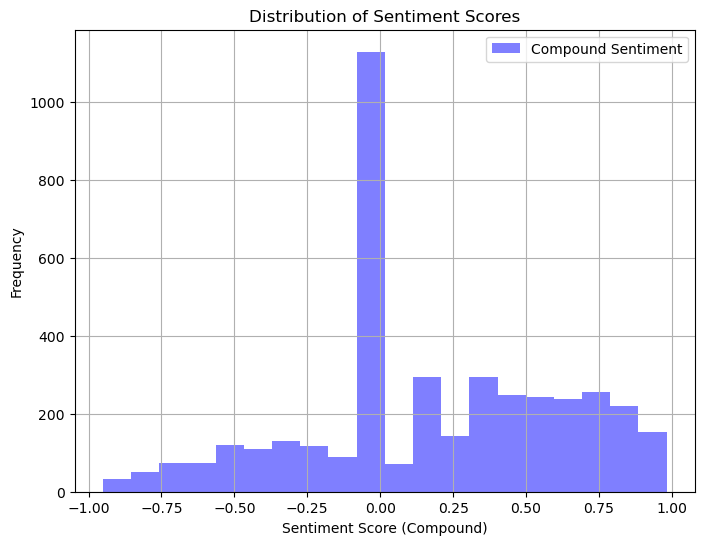

Wall time: 6.16 s


In [88]:
%%time
import unicodedata
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Lists to store sentiment scores
sentiment_scores = []
negative_scores = []
neutral_scores = []
positive_scores = []

# Iterate through the DataFrame rows
for index, row in sentiment_df.iterrows():
    try:
        # Normalize the text using Unicode normalization
        normalized_sentence = unicodedata.normalize('NFKD', row['Tweet'])
        
        # Perform sentiment analysis on the normalized sentence
        sentence_sentiment = sentiment_analyzer.polarity_scores(normalized_sentence)
        
        # Update the sentiment scores in the DataFrame
        sentiment_df.at[index, 'sentiment_score'] = sentence_sentiment['compound']
        sentiment_df.at[index, 'Negative'] = sentence_sentiment['neg']
        sentiment_df.at[index, 'Neutral'] = sentence_sentiment['neu']
        sentiment_df.at[index, 'Positive'] = sentence_sentiment['pos']
        
        # Append sentiment scores to lists for visualization
        sentiment_scores.append(sentence_sentiment['compound'])
        negative_scores.append(sentence_sentiment['neg'])
        neutral_scores.append(sentence_sentiment['neu'])
        positive_scores.append(sentence_sentiment['pos'])
    except TypeError:
        print(sentiment_df.loc[index, 'Tweet'])
        print(index)
        break

# Plot sentiment scores over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_scores, label='Sentiment Score (Compound)')
plt.xlabel('Tweet Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot the distribution of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(sentiment_scores, bins=20, alpha=0.5, color='blue', label='Compound Sentiment')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.legend()
plt.grid(True)
plt.show()


In [89]:

sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",0.25,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",0.7783,0.0,0.799,0.201


In [90]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df['Date'] = sentiment_df['Date'].dt.date
sentiment_df = sentiment_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [91]:
sentiment_df.head()

,Date,Tweet,sentiment_score
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783


In [92]:
twitter_df = sentiment_df.groupby([sentiment_df['Date']]).mean()
twitter_df

,sentiment_score
Date,
2021-09-30,0.246480
2021-10-01,0.359338
2021-10-02,-0.000700
2021-10-03,0.834400
2021-10-04,0.258650
...,...
2022-09-25,0.225867
2022-09-26,-0.068714
2022-09-27,-0.096700


Shape of the DataFrame: (6300, 8)
First few rows of the DataFrame:
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA  


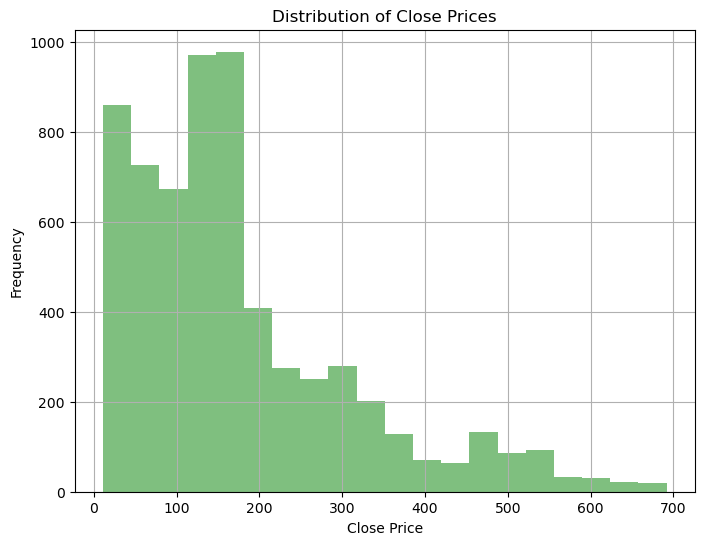

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
all_stocks = pd.read_csv("stock_yfinance_data.csv")

# Print the shape of the DataFrame
print("Shape of the DataFrame:", all_stocks.shape)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(all_stocks.head())

# Plot the distribution of 'Close' prices
plt.figure(figsize=(8, 6))
plt.hist(all_stocks['Close'], bins=20, alpha=0.5, color='green')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Distribution of Close Prices')
plt.grid(True)
plt.show()


In [94]:


stocks_df = all_stocks[all_stocks['Stock Name'] == "AMZN"]
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
stocks_df['Date'] = stocks_df['Date'].dt.date

In [95]:
stocks_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,AMZN
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,AMZN
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,AMZN
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,AMZN
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,AMZN
...,...,...,...,...,...,...,...,...
1255,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,AMZN
1256,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,AMZN
1257,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,AMZN
1258,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,AMZN


In [96]:
main_df = stocks_df.join(twitter_df, how="left", on="Date")
main_df = main_df.drop(columns=['Stock Name'])
main_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.246480
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359338
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.258650
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.045500
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.194300


In [17]:
twitter_df


,sentiment_score
Date,
2021-09-30,0.246480
2021-10-01,0.359338
2021-10-02,-0.000700
2021-10-03,0.834400
2021-10-04,0.258650
...,...
2022-09-25,0.225867
2022-09-26,-0.068714
2022-09-27,-0.096700


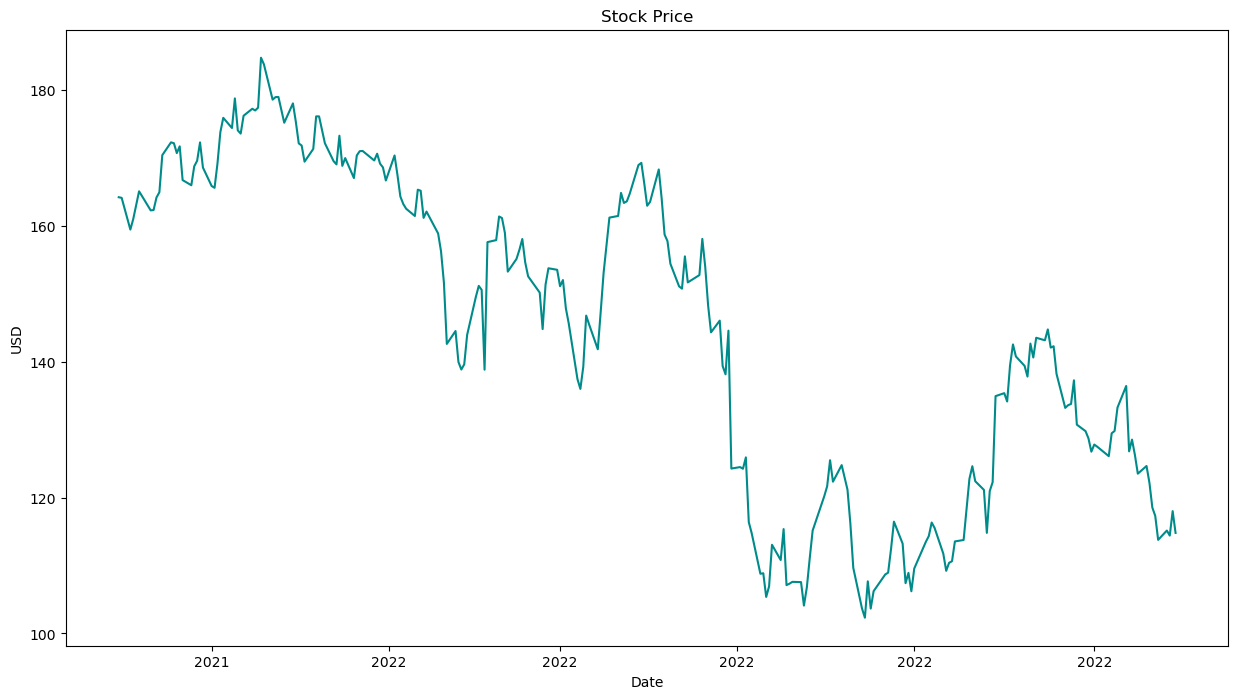

In [98]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the stock's date and close price
ax.plot(main_df['Date'], main_df['Close'], color='#008B8B')

# Set labels and title
ax.set(xlabel="Date", ylabel="USD", title=f"Stock Price")

# Format the x-axis to display years
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# Display the plot
plt.show()


In [100]:

def calculate_technical_indicators(data):
    # Calculate 7-day Simple Moving Average (SMA) for the closing price
    data['SMA_7'] = data['Close'].rolling(window=7).mean()
    
    # Calculate 20-day Simple Moving Average (SMA) for the closing price
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    
    # Calculate Moving Average Convergence Divergence (MACD)
    ema_26 = data['Close'].ewm(span=26).mean()
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    
    # Calculate Bollinger Bands
    data['20SD'] = data['Close'].rolling(20).std()
    data['Upper_Band'] = data['SMA_20'] + (data['20SD'] * 2)
    data['Lower_Band'] = data['SMA_20'] - (data['20SD'] * 2)
    
    # Calculate Exponential Moving Average (EMA)
    data['EMA'] = data['Close'].ewm(com=0.5).mean()
    
    # Calculate Log-Momentum
    data['Log_Momentum'] = np.log(data['Close'] - 1)
    
    return data


In [20]:
tech_df = calculate_technical_indicators(main_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset



,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,SMA_7,SMA_20,MACD,20SD,Upper_Band,Lower_Band,EMA,Log_Momentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,0.935538,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,0.843851,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,0.587288,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,0.361458,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.419097,3.324309,174.341469,161.044234,168.175464,5.125154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,-0.104025,120.898572,126.408000,-3.637142,5.361500,137.130999,115.685000,115.259321,4.725439
228,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,-0.068714,119.308572,125.628000,-3.992572,5.812371,137.252742,114.003258,115.186441,4.737513
229,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,-0.096700,118.005716,124.859000,-4.284575,6.234807,137.328614,112.389387,114.668816,4.731010
230,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,0.394520,117.055715,124.323001,-4.177345,6.344338,137.011676,111.634325,116.896273,4.762259


In [21]:
tech_df

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,SMA_7,SMA_20,MACD,20SD,Upper_Band,Lower_Band,EMA,Log_Momentum
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.246480,NaN,NaN,0.000000,NaN,NaN,NaN,164.251999,5.095295
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359338,NaN,NaN,0.032521,NaN,NaN,NaN,164.185246,5.094750
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.258650,NaN,NaN,0.996554,NaN,NaN,NaN,160.933998,5.065685
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.045500,NaN,NaN,1.026911,NaN,NaN,NaN,161.012301,5.075486
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.194300,NaN,NaN,0.791034,NaN,NaN,NaN,162.410183,5.088216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,-0.104025,120.898572,126.408000,-3.637142,5.361500,137.130999,115.685000,115.259321,4.725439
1256,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,-0.068714,119.308572,125.628000,-3.992572,5.812371,137.252742,114.003258,115.186441,4.737513
1257,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,-0.096700,118.005716,124.859000,-4.284575,6.234807,137.328614,112.389387,114.668816,4.731010
1258,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,0.394520,117.055715,124.323001,-4.177345,6.344338,137.011676,111.634325,116.896273,4.762259


In [22]:
def tech_ind(dataset):
    fig, ax = plt.subplots(figsize=(15, 8), dpi=200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['SMA_7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['SMA_20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()


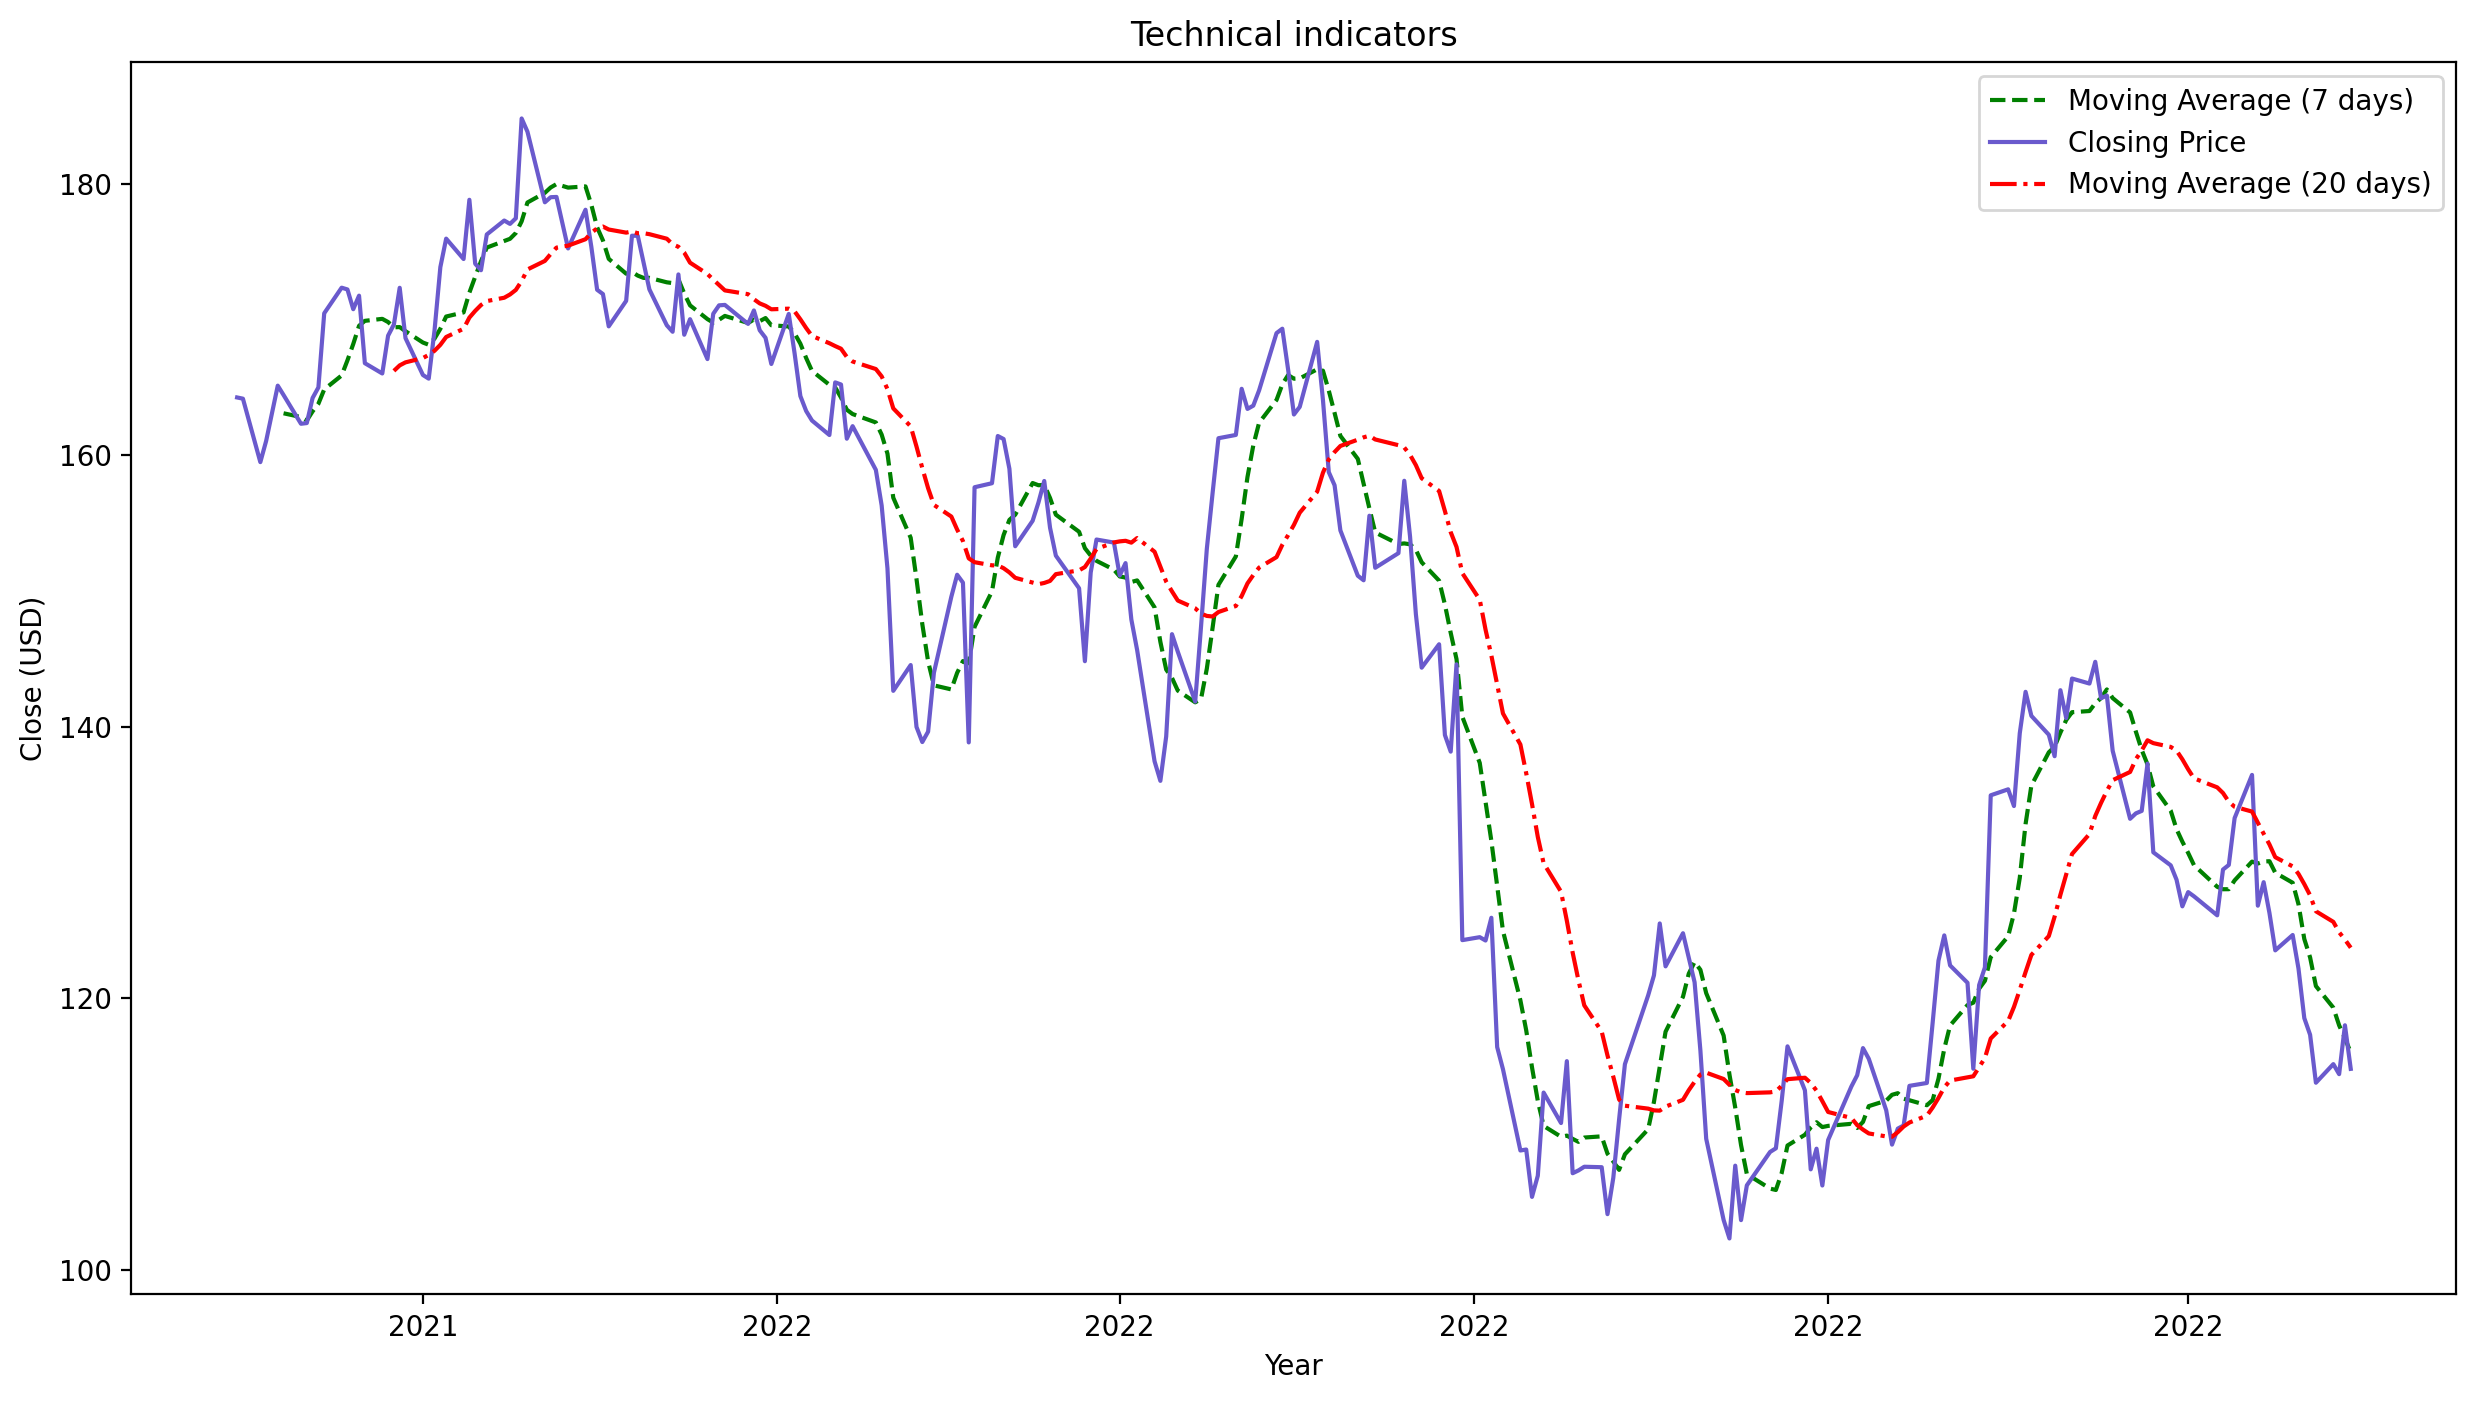

In [23]:
#display the plot
tech_ind(tech_df)

In [24]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [25]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,SMA_7,SMA_20,MACD,20SD,Upper_Band,Lower_Band,EMA,Log_Momentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,0.935538,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,0.843851,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.373936,168.297071,167.158501,0.587288,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,0.361458,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.419097,3.324309,174.341469,161.044234,168.175464,5.125154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-23,116.000000,116.050003,112.059998,113.779999,113.779999,65126700,-0.104025,120.898572,126.408000,-3.637142,5.361500,137.130999,115.685000,115.259321,4.725439
228,2022-09-26,113.300003,117.339996,113.129997,115.150002,115.150002,62723300,-0.068714,119.308572,125.628000,-3.992572,5.812371,137.252742,114.003258,115.186441,4.737513
229,2022-09-27,117.199997,118.320000,113.050003,114.410004,114.410004,60094700,-0.096700,118.005716,124.859000,-4.284575,6.234807,137.328614,112.389387,114.668816,4.731010
230,2022-09-28,114.379997,118.699997,113.800003,118.010002,118.010002,55763800,0.394520,117.055715,124.323001,-4.177345,6.344338,137.011676,111.634325,116.896273,4.762259


In [26]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')


In [102]:
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

def normalize_data(df, feature_range, target_column_name):

    # Extract the target column as a DataFrame series
    target_series = df[target_column_name]

    # Create a copy of the original DataFrame
    data = df.copy()

    # Initialize MinMaxScaler for features and the target separately
    feature_scaler = MinMaxScaler(feature_range=feature_range)
    target_scaler = MinMaxScaler(feature_range=feature_range)

    # Fit the scalers on the data
    feature_scaler.fit(data)
    target_scaler.fit(target_series.to_numpy().reshape(-1, 1))

    # Transform the data using the fitted scalers
    scaled_features = feature_scaler.transform(data)
    scaled_target = target_scaler.transform(target_series.to_numpy().reshape(-1, 1))

    # Save the scalers to files (optional)
    dump(feature_scaler, open('feature_scaler.pkl', 'wb'))
    dump(target_scaler, open('target_scaler.pkl', 'wb'))

    return scaled_features, scaled_target


In [28]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [29]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [30]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [122]:
# Normalize the data
X_scaled, y_scaled = normalize_data(dataset, (-1, 1), "Close")

# Batch the data
batch_size = 5
predict_period = 1
X_batched, y_batched, yc = batch_data(X_scaled, y_scaled, batch_size, predict_period)

# Print shapes
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

# Split data into train and test sets
X_train, X_test = split_train_test(X_batched)
y_train, y_test = split_train_test(y_batched)
yc_train, yc_test = split_train_test(yc)

# Predict index
index_train, index_test = predict_index(dataset, X_train, batch_size, predict_period)


X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [34]:
dataset.shape

(232, 15)

In [35]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [36]:
#making the GAN Model 

In [124]:


def make_generator_model(input_dim, output_dim, feature_size):
    # Create a Sequential model
    model = tf.keras.Sequential()

    # Add LSTM layers with return_sequences=True for sequence generation
    model.add(tf.keras.layers.LSTM(units=1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3))
    model.add(tf.keras.layers.LSTM(units=512, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.LSTM(units=256, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=False, recurrent_dropout=0.3))

    # Add Dense layers for further processing
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dense(8))

    # Output layer with units=output_dim
    model.add(tf.keras.layers.Dense(units=output_dim))

    return model


In [125]:

def make_discriminator_model(input_dim):
    # Create a Sequential model
    model = tf.keras.Sequential()

    # Add Conv1D layers with LeakyReLU activation
    model.add(tf.keras.layers.Conv1D(8, input_shape=(input_dim + 1, 1), kernel_size=3, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

    model.add(tf.keras.layers.Conv1D(16, kernel_size=3, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

    model.add(tf.keras.layers.Conv1D(32, kernel_size=3, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

    model.add(tf.keras.layers.Conv1D(64, kernel_size=3, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

    model.add(tf.keras.layers.Conv1D(128, kernel_size=1, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.01))

    # Additional LeakyReLU activation
    model.add(tf.keras.layers.LeakyReLU())

    # Dense layers with or without bias
    model.add(tf.keras.layers.Dense(220, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Dense(220, use_bias=False, activation='relu'))

    # Output layer with sigmoid activation
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model


In [126]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [129]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [130]:

def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint=50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        # Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_{epoch}.h5')
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_{epoch}.h5')
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    # Visualize training progress
    plt.subplot(2, 1, 1)
    plt.plot(train_info["discriminator_loss"], label='Discriminator Loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_info["generator_loss"], label='Generator Loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)


In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pickle import load

def plot_results(Real_price, Predicted_price, index_train):
    # Load scalers
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))

    train_predict_index = index_train
    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    # Create DataFrames for predicted and real prices
    predict_result = pd.DataFrame()
    real_price = pd.DataFrame()

    # Fill DataFrames with predicted and real prices
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    # Calculate the mean of predicted and real prices
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate and print RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)


In [132]:
## Test Code

@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [133]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [134]:


# Define hyperparameters
learning_rate = 5e-4
epochs = 500

# Create optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create generator and discriminator models
generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])


In [135]:
from tensorflow.keras.utils import plot_model

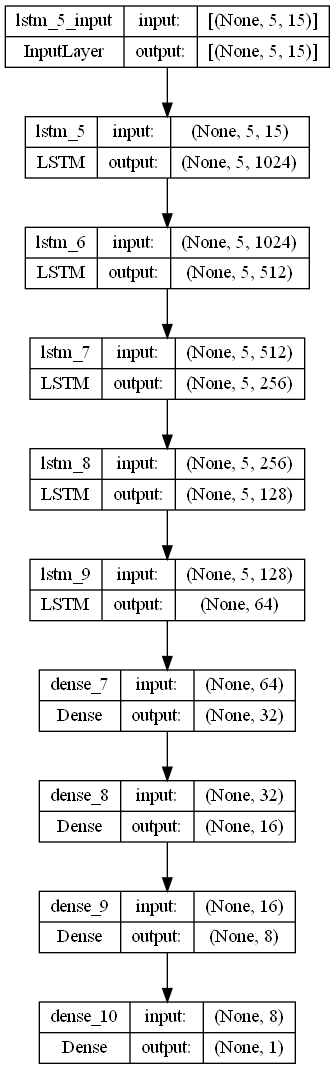

In [136]:

plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)


In [137]:
#train and test the model

 10%|███████▉                                                                         | 49/500 [02:03<15:16,  2.03s/it]

 10%|████████                                                                         | 50/500 [02:05<16:33,  2.21s/it]

epoch 50 discriminator_loss 1.4035791 generator_loss 0.6883135


 20%|████████████████                                                                 | 99/500 [03:49<13:58,  2.09s/it]

 20%|████████████████                                                                | 100/500 [03:51<14:34,  2.19s/it]

epoch 100 discriminator_loss 1.3935997 generator_loss 0.68759197


 30%|███████████████████████▊                                                        | 149/500 [05:35<12:11,  2.09s/it]

 30%|████████████████████████                                                        | 150/500 [05:37<12:23,  2.12s/it]

epoch 150 discriminator_loss 1.3830044 generator_loss 0.69658244


 40%|███████████████████████████████▊                                                | 199/500 [07:20<10:39,  2.12s/it]

epoch

 40%|████████████████████████████████                                                | 200/500 [07:22<10:52,  2.17s/it]

 200 discriminator_loss 1.3907335 generator_loss 0.69062114


 50%|███████████████████████████████████████▊                                        | 249/500 [09:06<08:42,  2.08s/it]

 50%|████████████████████████████████████████                                        | 250/500 [09:08<08:55,  2.14s/it]

epoch 250 discriminator_loss 1.3663397 generator_loss 0.73426044


 60%|███████████████████████████████████████████████▊                                | 299/500 [10:52<07:13,  2.16s/it]

 60%|████████████████████████████████████████████████                                | 300/500 [10:54<07:20,  2.20s/it]

epoch 300 discriminator_loss 1.3894721 generator_loss 0.6908541


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [12:37<05:12,  2.07s/it]

 70%|████████████████████████████████████████████████████████                        | 350/500 [12:40<05:20,  2.14s/it]

epoch 350 discriminator_loss 1.3883269 generator_loss 0.6927247


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [14:23<03:31,  2.09s/it]

 80%|████████████████████████████████████████████████████████████████                | 400/500 [14:25<03:32,  2.12s/it]

epoch 400 discriminator_loss 1.3868886 generator_loss 0.6947457


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [16:08<01:45,  2.07s/it]

 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [16:10<01:47,  2.14s/it]

epoch 450 discriminator_loss 1.3863597 generator_loss 0.69413793


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [17:53<00:02,  2.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [17:55<00:00,  2.15s/it]

epoch 500 discriminator_loss 1.3864231 generator_loss 0.6936939


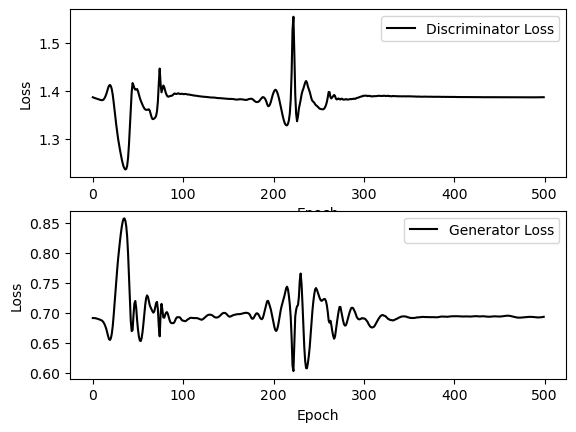

In [138]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [139]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5',compile=False)


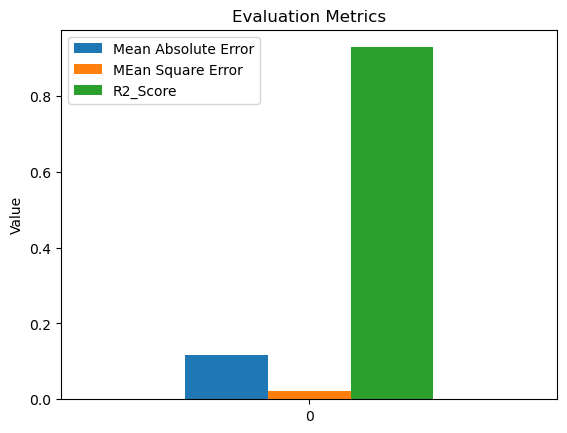

In [140]:
#evaluation Metrics 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


MAE=mean_absolute_error(real_price,predicted_price)
MSE = mean_squared_error(real_price,predicted_price)
r1 = r2_score(real_price,predicted_price)


Metrics_df=pd.DataFrame({"Mean Absolute Error":[MAE],"MEan Square Error":[MSE],"R2_Score":[r1]})

Metrics_df

Metrics_df.plot(kind='bar')
plt.title('Evaluation Metrics')
plt.ylabel('Value')
plt.xticks(rotation=0)  # To ensure the metric names are not rotated on the x-axis
plt.show()


In [141]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

ValueError: non-broadcastable output operand with shape (20,1) doesn't match the broadcast shape (20,15)

In [ ]:
import os
print(os.getcwd())
